### This notebook will utilize a standard BERT model

### Just using the Title string as the feature

### The input to the neural network will be the pooled_token from BERT

### Output will be whether or not the question has a score of higher than 1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import class_weight

2022-11-23 13:19:27.815830: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from transformers import BertTokenizer, TFBertModel

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

2022-11-23 13:19:34.172375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-23 13:19:34.193457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-23 13:19:34.193473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-23 13:19:34.193864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [4]:
# bring in the data
questions_data = pd.read_csv("processed_questions.csv")

In [5]:
questions_data.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count
0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70
1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38


In [6]:
train, test = train_test_split(questions_data, test_size=0.2)

In [7]:
train_examples = list(train['Title'])
train_labels = list(train['has_positive_answer'])

In [8]:
test_examples = list(test['Title'])
test_labels = list(test['has_positive_answer'])

In [9]:
max_length = 20 # seems like this encompasses most titles

In [10]:
x_train = bert_tokenizer(train_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = tf.convert_to_tensor(train_labels)

In [11]:
x_test = bert_tokenizer(test_examples,
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = tf.convert_to_tensor(test_labels)

In [12]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [13]:
bert_classification_model = create_bert_classification_model(bert_model, train_layers=-1)

In [14]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                              

In [23]:
y_train.numpy()

array([1, 1, 1, ..., 0, 1, 0], dtype=int32)

In [26]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.5179754286856972, 1: 0.7455854954404683}

In [27]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    valida  tion_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=1,
    class_weight=class_weights_dict
)  

15183/15183 [==============================] - 5574s 367ms/step - loss: 0.6847 - accuracy: 0.5544 - val_loss: 0.6623 - val_accuracy: 0.6089


In [ ]:
# how to make confusion matrix:
# https://androidkt.com/keras-confusion-matrix-in-tensorboard/

In [ ]:
# https://www.tensorflow.org/guide/keras/save_and_serialize
# how to save models

In [28]:
bert_classification_model.save('models/bert-model-pooled-token-class-weights')

INFO:tensorflow:Assets written to: models/bert-model-pooled-token-class-weights/assets


INFO:tensorflow:Assets written to: models/bert-model-pooled-token-class-weights/assets


In [12]:
bert_classification_model = keras.models.load_model('models/bert-model-pooled-token-class-weights')

In [13]:
y_pred_raw = bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])

3796/3796 [==============================] - 1038s 273ms/step


In [14]:
y_pred = (y_pred_raw > 0.5).astype(int)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

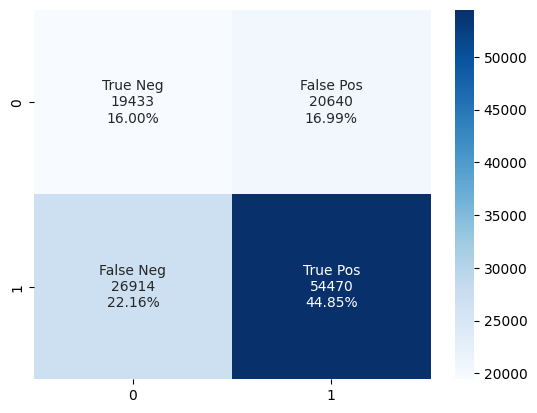

In [16]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [17]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_raw)
auc = metrics.roc_auc_score(y_test, y_pred_raw)

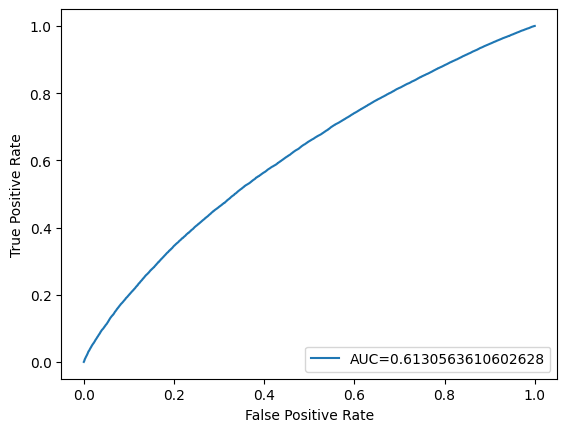

In [18]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [20]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.6961289250706097
precision score is: 0.7252030355478631
recall score is: 0.6692961761525607
